# Painting Classifier by Style

## Imports

In [22]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import PIL
pd.options.mode.chained_assignment = None  # default='warn'

from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, RandomFlip, RandomZoom, RandomRotation
from keras.utils import to_categorical
from keras.applications.resnet_v2 import ResNet50V2


## Loading in the data

In [23]:
df = pd.read_csv("all_data_info.csv")
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


## Visualizing some of the art 

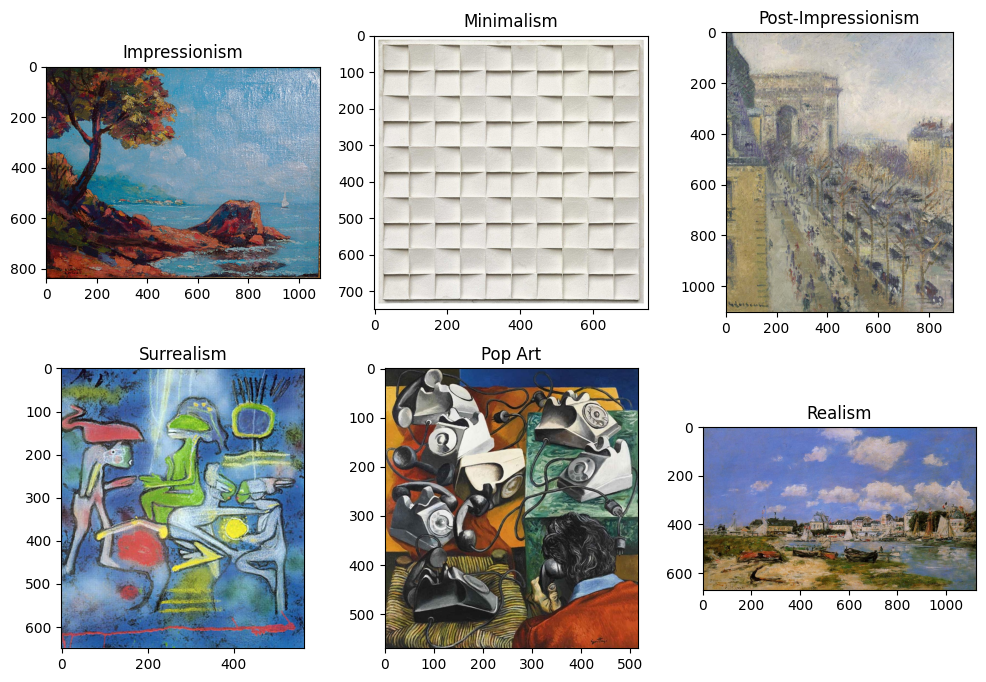

In [24]:
train_1_folder = "/Users/aryan/Desktop/train_3"

# create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the first 6 images
for i in range(6):
    # get the image path and read the image
    img_name = os.listdir(train_1_folder)[i]
    img_path = os.path.join(train_1_folder, img_name)
    img = plt.imread(img_path)
    
    # find the corresponding row in the DataFrame
    row = df[df["new_filename"] == img_name].iloc[0]
    
    # get the artist, title, and style information
    artist = row["artist"]
    title = row["title"]
    style = row["style"]
    
    # plot the image in the appropriate subplot
    row_index, col_index = divmod(i, 3)
    axs[row_index, col_index].imshow(img)
    axs[row_index, col_index].set_title(style)

# show the figure
plt.show()

## Preprocessing

It is evident we have a ton of data to work with. Let's take a deeper look into the Style column since we will be working with it extensively.

In [25]:
df["style"].value_counts()

Impressionism               10643
Realism                     10523
Romanticism                  9285
Expressionism                7013
Post-Impressionism           5778
                            ...  
Spectralism                     5
Kinetic Art                     3
Ilkhanid                        2
Renaissance                     1
Environmental (Land) Art        1
Name: style, Length: 136, dtype: int64

There is a huge imbalance in the data here. We have 5 instances of artworks that fall under the spectralism category and have more than 10,000 impressionism style paintings. We would be naive to train our model on the dataset as is. We need to filter out styles that do not have enough samples and also those that have too many. Here, the choice for the threshold is really arbitrary and we decided to work with art styles with 2,000 samples. This means that styles like realism with several thousands of paintings need to be cut down to as close to 2,000 as possible.

Text(0.5, 0, 'Number of paintings')

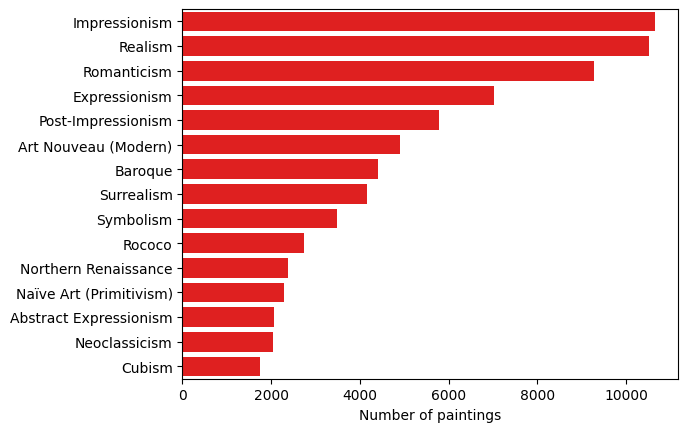

In [26]:
df["style"].value_counts()[:15]

sns.barplot(x=df["style"].value_counts()[:15].values, y=df["style"].value_counts()[:15].index,
            color="r")
plt.xlabel("Number of paintings")

There is a huge imbalance in the data here. We have 5 instances of artworks that fall under the spectralism category and have more than 10,000 impressionism style paintings. We would be naive to train our model on the dataset as is. We need to filter out styles that do not have enough samples and also those that have too many. Here, the choice for the threshold is really arbitrary and we decided to work with art styles with 200 samples. This means that styles like realism with several thousands of paintings need to be cut down to as close to 200 as possible.

In [27]:
overpop_styles = df["style"].value_counts()[:10].index.tolist()
overpop_styles

['Impressionism',
 'Realism',
 'Romanticism',
 'Expressionism',
 'Post-Impressionism',
 'Art Nouveau (Modern)',
 'Baroque',
 'Surrealism',
 'Symbolism',
 'Rococo']

In [28]:
def style_balancer(style_arr, df):
    """
    Reduce the number of samples for each overpopulated style in the given DataFrame to match the count of the
    least represented style, and return a new DataFrame with the reduced number of samples for each style.

    Parameters:
        style_arr (list of str): A list of style names to balance.
        df (pandas.DataFrame): The DataFrame containing the samples to balance.

    Returns:
        pandas.DataFrame: A new DataFrame with the reduced number of samples for each style.

    Raises:
        None

    """

    # Get the minimum number of samples for any style in the DataFrame
    min_val = df["style"].value_counts()[9]

    # Initialize an empty DataFrame variable to hold the balanced samples for all styles
    empty_df_var = None

    # Loop through each style in the style_arr list
    for _style in style_arr:
        # Create a boolean mask to select only the samples with the current style
        style_mask = df["style"] == _style

        # Create a new DataFrame with only the samples with the current style
        style_df = df[style_mask]

        # Calculate the total number of samples for the current style
        tot = len(style_df.index)

        # Calculate the number of samples to remove to match the minimum count
        rmv = tot - min_val

        # Remove the excess samples from the current style DataFrame
        style_df.drop(style_df.index[range(rmv)], inplace=True)

        # Concatenate the current style DataFrame to the empty_df_var DataFrame to add it to the new DataFrame
        fin_df = pd.concat([empty_df_var, style_df], ignore_index=True)

        # Update the empty_df_var DataFrame with the new DataFrame containing the current style
        empty_df_var = fin_df

    # Return the final DataFrame containing the balanced samples for all styles
    return fin_df


df = style_balancer(overpop_styles, df)
df["style"].value_counts()


Impressionism           2733
Realism                 2733
Romanticism             2733
Expressionism           2733
Post-Impressionism      2733
Art Nouveau (Modern)    2733
Baroque                 2733
Surrealism              2733
Symbolism               2733
Rococo                  2733
Name: style, dtype: int64

Let's also write a function that can tell us what style an image belongs to. This can come in handy to test individual examples and compare the predicted vs true label.

In [29]:
def style_returner(img_name):
    for i in range(len(df)):
        if img_name == df.loc[i, "new_filename"]:
            return df.loc[i, "style"]
        
style_returner('1165.jpg')

'Impressionism'

## Prepare data for training

### Shuffle data

In [30]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

df["in_train"].value_counts()
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Theophrastos Triantafyllidis,NaN,genre painting,615.0,653.0,115622.0,wikiart,Impressionism,Photographer,train_only,True,21641.jpg
1,Anthony van Dyck,1634,portrait,440.0,831.0,21816.0,wikiart,Baroque,"Portrait of Henri II de Lorraine, Duc de Guise",train_and_test,True,61995.jpg
2,Benjamin West,NaN,genre painting,1021.0,810.0,378593.0,wikiart,Rococo,A Domestic Affliction,train_and_test,True,49806.jpg
3,Maxfield Parrish,1908.0,symbolic painting,488.0,599.0,78185.0,wikiart,Symbolism,The Lantern Bearers,train_and_test,True,98563.jpg
4,John Hoppner,1797.0,portrait,500.0,620.0,27961.0,wikipedia,Romanticism,"Jane Elizabeth, Countess of Oxford",train_only,True,15996.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
27325,Theophile Steinlen,1892.0,illustration,593.0,768.0,64498.0,wikiart,Art Nouveau (Modern),Ballade du Ventre,train_and_test,True,84696.jpg
27326,Robert Brackman,NaN,still life,500.0,392.0,82607.0,wikiart,Realism,An Etude in Gray #2,train_only,True,82873.jpg
27327,Salvador Dali,1925,nude painting (nu),640.0,957.0,96695.0,wikiart,Symbolism,Double-sided Verso (Studio Scene),train_and_test,True,51443.jpg
27328,Theodore Rousseau,NaN,landscape,758.0,534.0,61399.0,wikiart,Realism,The pond at the foot of the hill,train_and_test,True,50803.jpg


In [31]:
PIL.Image.MAX_IMAGE_PIXELS = 933120000

# Loop through each file in the training folder and remove corrupted images from the training set dataframe
for filename in os.listdir(train_1_folder):
    try:
        img = Image.open(os.path.join(train_1_folder, filename))
        img.verify()
    except (IOError, SyntaxError) as e:
        print('Bad file:', filename, e)
        train_df = train_df[train_df['new_filename'] != filename] # Remove the corrupted image from the training set dataframe



In [32]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define data generators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow_from_dataframe generator for the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

Found 3577 validated image filenames belonging to 10 classes.
Found 859 validated image filenames belonging to 10 classes.


/opt/homebrew/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 18287 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4607 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


## Number of samples for each class in training set

In [33]:
class_indices = train_generator.class_indices
classes = train_generator.classes

newd = {key: 0 for key in class_indices}

for i in classes:
    for j, k in class_indices.items():
        if i == k:
            newd[j] += 1

newd

{'Art Nouveau (Modern)': 400,
 'Baroque': 349,
 'Expressionism': 361,
 'Impressionism': 380,
 'Post-Impressionism': 354,
 'Realism': 337,
 'Rococo': 367,
 'Romanticism': 365,
 'Surrealism': 311,
 'Symbolism': 353}

## Number of samples for each class in testing set

In [34]:
class_indices = test_generator.class_indices
classes = test_generator.classes

newd = {key: 0 for key in class_indices}

for i in classes:
    for j, k in class_indices.items():
        if i == k:
            newd[j] += 1

newd

{'Art Nouveau (Modern)': 86,
 'Baroque': 80,
 'Expressionism': 70,
 'Impressionism': 86,
 'Post-Impressionism': 92,
 'Realism': 79,
 'Rococo': 97,
 'Romanticism': 78,
 'Surrealism': 102,
 'Symbolism': 89}

## Model architecture

The model consists of convolutional layers followed by max pooling layers to extract features from the input images. A dropout layer is included for regularization. The flattened features are then passed through fully connected layers, with the final layer using softmax activation for multi-class classification. The model is compiled with the Adam optimizer and evaluated using accuracy as the metric.

In [35]:
# define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)),
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(14, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

## Train model

In [36]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

Epoch 1/10
112/112 [==============================] - 85s 748ms/step - loss: 2.3500 - accuracy: 0.1594 - val_loss: 2.1739 - val_accuracy: 0.2084
Epoch 2/10
112/112 [==============================] - 80s 714ms/step - loss: 2.1644 - accuracy: 0.1974 - val_loss: 2.1564 - val_accuracy: 0.2095
Epoch 3/10
112/112 [==============================] - 81s 718ms/step - loss: 2.1348 - accuracy: 0.2242 - val_loss: 2.1606 - val_accuracy: 0.2002
Epoch 4/10
112/112 [==============================] - 80s 714ms/step - loss: 2.0959 - accuracy: 0.2309 - val_loss: 2.0621 - val_accuracy: 0.2526
Epoch 5/10
112/112 [==============================] - 130s 1s/step - loss: 2.0644 - accuracy: 0.2413 - val_loss: 2.0957 - val_accuracy: 0.2305
Epoch 6/10
112/112 [==============================] - 234s 2s/step - loss: 2.0407 - accuracy: 0.2592 - val_loss: 2.1389 - val_accuracy: 0.2247
Epoch 7/10
112/112 [==============================] - 80s 710ms/step - loss: 2.0056 - accuracy: 0.2653 - val_loss: 2.0776 - val_accura

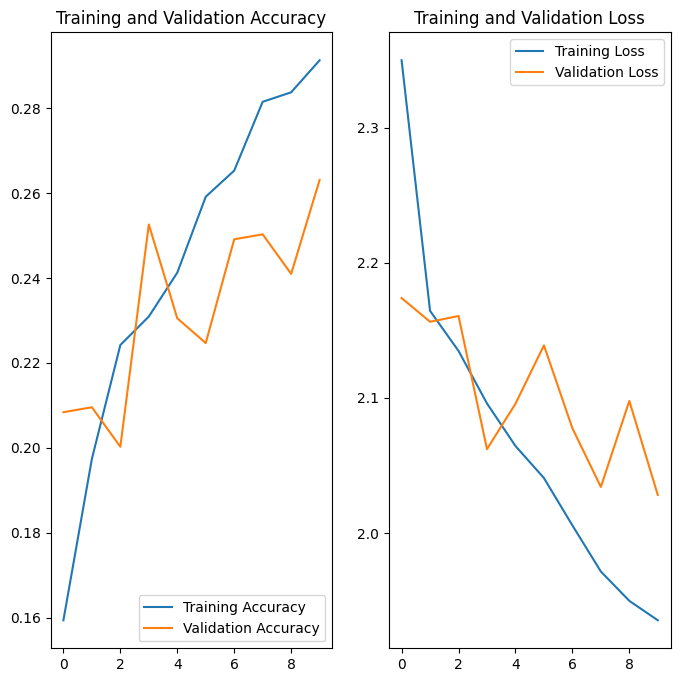

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Although the training and validation accuracy increase together (not overfitting) the model still performs poorly, reaching a maximum accuracy of 25% upon multiple reruns. The model's poor performance could be attributed to the relatively small dataset it is presented with during training, limiting the model's ability to generalize effectively, or the architecture might be too simplistic, lacking the necessary depth and complexity to understand the nuances of different art styles.

27/27 [==============================] - 8s 297ms/step


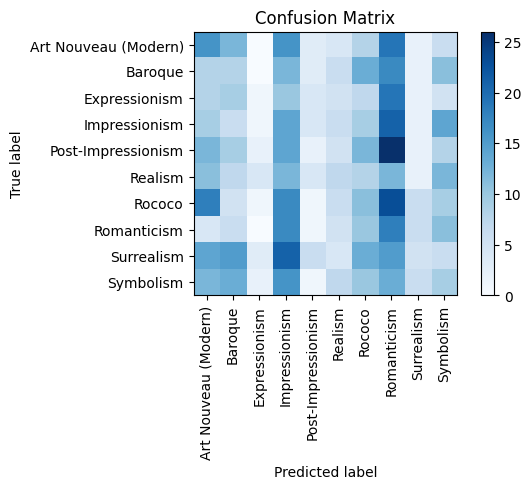

In [38]:
# Get the true labels and predicted labels for the test data
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

To investigate whether the problem lies in the model architecture, we will utilize a pretrained model that is significantly more complex than the one we built. By comparing its performance to our model, we can determine if our model's poor performance is indeed due to its architecture. 

If the pretrained model demonstrates exceptional performance, it would strongly indicate that our model was not adequately designed to capture the necessary patterns and features for the art style classification task.

## ResNet model 

In [39]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(14, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [40]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))

# Print the accuracy
print("Accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
112/112 [==============================] - 122s 1s/step - loss: 2.2340 - accuracy: 0.2390 - val_loss: 1.8317 - val_accuracy: 0.3667
Epoch 2/10
112/112 [==============================] - 121s 1s/step - loss: 1.8562 - accuracy: 0.3313 - val_loss: 1.6898 - val_accuracy: 0.3935
Epoch 3/10
112/112 [==============================] - 121s 1s/step - loss: 1.7541 - accuracy: 0.3741 - val_loss: 1.6421 - val_accuracy: 0.4075
Epoch 4/10
112/112 [==============================] - 123s 1s/step - loss: 1.6455 - accuracy: 0.4003 - val_loss: 1.6115 - val_accuracy: 0.4191
Epoch 5/10
112/112 [==============================] - 122s 1s/step - loss: 1.5925 - accuracy: 0.4247 - val_loss: 1.5829 - val_accuracy: 0.4237
Epoch 6/10
112/112 [==============================] - 122s 1s/step - loss: 1.5436 - accuracy: 0.4423 - val_loss: 1.5744 - val_accuracy: 0.4529
Epoch 7/10
112/112 [==============================] - 121s 1s/step - loss: 1.4861 - accuracy: 0.4641 - val_loss: 1.5455 - val_accuracy: 0.4400

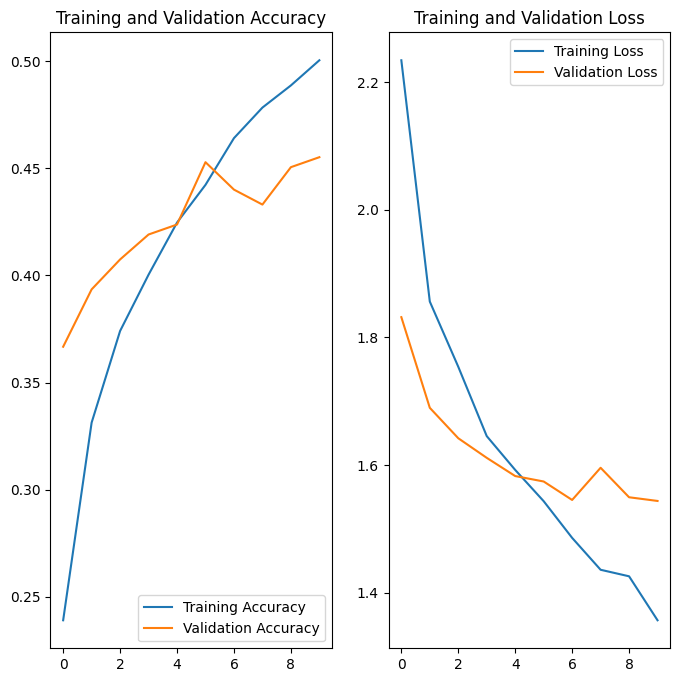

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As anticipated, the ResNet model exhibits improved performance compared to our previous model. However, the increase in accuracy is not substantial, reaching only 45%. This outcome supports our initial hypothesis that the primary issue is the insufficiency of training data rather than inherent limitations in the model architecture.

27/27 [==============================] - 24s 871ms/step


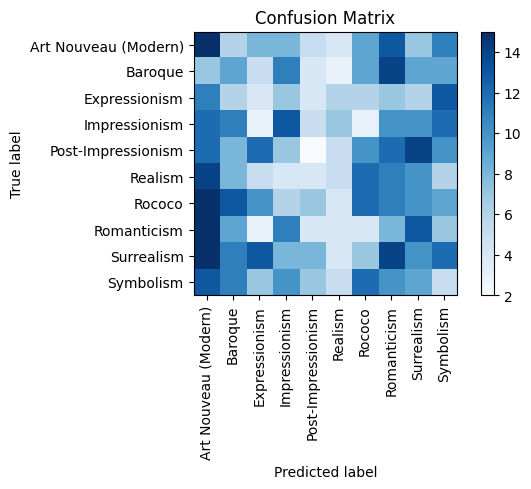

In [42]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Another crucial observation is that the misclassifications made by the ResNet model can be attributed to the data imbalance. While the model was trained with approximately 350 examples per class, the Art Nouveau style had 400 examples. Consequently, the model tends to misclassify other styles as Art Nouveau more frequently, as it has encountered this style more frequently during training. 

It is important to note that this data imbalance occurred due to limitations in downloading the complete dataset, which contained hundreds of thousands of images. As a result, the mini dataset used for training could not be adequately cleaned and balanced.

## Conclusion

This project's objective was to develop a deep learning model to classify paintings based on their art style. The model architecture initially constructed yielded subpar results, with an accuracy of only 18.8%. 

Upon analyzing the performance, it is likely the poor accuracy can be attributed to the very limited dataset, with 350 samples per class on average. The data imbalance, particularly in the case of Art Nouveau with 400 examples, also introduced biases and misclassifications.

Furthermore, due to computer limitations, it was not possible to download the full dataset containing hundreds of thousands of images. As a result, the mini dataset used for training was not adequately cleaned and balanced, further impacting the model's performance.

To improve the project's outcomes, several steps can be taken. Firstly, exploring more complex and deeper model architectures, such as deeper convolutional neural networks or pre-trained models specifically trained on art-related datasets, could enhance the model's ability to capture the unique characteristics of different art styles.

Additionally, increasing the size and diversity of the training dataset would likely lead to better generalization and reduce biases. Collecting more samples for underrepresented art styles and addressing the data imbalance would be crucial.

In summary, while the initial model's accuracy was low at 18.8%, the analysis revealed that both the model's architecture and the limited training dataset were contributing factors, with the the data itself being the leading factor. By addressing these issues and incorporating more sophisticated models, as well as obtaining a more comprehensive and balanced training dataset, the classification accuracy for art style recognition can be significantly improved.